In [817]:
import os
from dateutil.tz import gettz
import pandas as pd
import numpy as np

SRC_HOUSE_DATASET_PATH = os.path.abspath("..\\shared_storage\\datasets\\src\\apartment_house\\1.db")
SRC_BOILER_DATASET_PATH = os.path.abspath("..\\shared_storage\\datasets\\src\\boilers\\144.db")

start_timestamp = pd.Timestamp(2021,12,1,0,0,0, tz=gettz("Asia/Yekaterinburg"))
end_timestamp = pd.Timestamp(2022,3,1,0,0,0, tz=gettz("Asia/Yekaterinburg"))

time_tick = pd.Timedelta(minutes=3)

In [799]:
from boiler.constants import column_names
from boiler.data_processing.timestamp_parsing_algorithm import SimpleTimestampParsingAlgorithm

import sqlite3


def parse_from_conn(con):
    df = pd.read_sql("SELECT * FROM meter_measurements", con)
    df = df[df["service"]=="OV"] 
    df = df[["d_timestamp", "t1"]]
    
    df["t1"] = df["t1"].apply(float)
    timestamp_parser = SimpleTimestampParsingAlgorithm(
        datetime_patterns=(
            r"(?P<year>\d{4})-(?P<month>\d{2})-(?P<day>\d{2})\s(?P<hours>\d{2}):(?P<minutes>\d{2}).{7}",
            r"(?P<day>\d{2})\.(?P<month>\d{2})\.(?P<year>\d{4})\s(?P<hours>\d{1,2}):(?P<minutes>\d{2})"
        ), 
        timezone=gettz("Asia/Yekaterinburg")
    )
    df["d_timestamp"] = df["d_timestamp"].apply(timestamp_parser.parse_datetime)
    
    df = df.rename(columns={"t1": column_names.FORWARD_TEMP, "d_timestamp": column_names.TIMESTAMP})

    return df

In [800]:
from boiler.data_processing.beetween_filter_algorithm import LeftClosedTimestampFilterAlgorithm
from boiler.data_processing.timestamp_interpolator_algorithm import TimestampInterpolationAlgorithm
from boiler.data_processing.timestamp_round_algorithm import NearestTimestampRoundAlgorithm
from boiler.data_processing.value_interpolation_algorithm import \
    LinearInsideValueInterpolationAlgorithm, \
    LinearOutsideValueInterpolationAlgorithm

timestamp_filter = LeftClosedTimestampFilterAlgorithm()
timestamp_rounder = NearestTimestampRoundAlgorithm(time_tick)
timestamp_interpolator = TimestampInterpolationAlgorithm(timestamp_rounder, time_tick)
inside_interpolator = LinearInsideValueInterpolationAlgorithm()
outside_interpolator = LinearOutsideValueInterpolationAlgorithm()

In [801]:
con = sqlite3.connect(SRC_HOUSE_DATASET_PATH)
house_df = parse_from_conn(con)

house_df = timestamp_filter.filter_df_by_min_max_timestamp(house_df, start_timestamp, end_timestamp)
house_df[column_names.TIMESTAMP] = timestamp_rounder.round_series(house_df[column_names.TIMESTAMP])
house_df = house_df.drop_duplicates(subset=[column_names.TIMESTAMP])
house_df = timestamp_interpolator.process_df(house_df, start_timestamp, end_timestamp)
house_df[column_names.FORWARD_TEMP] = outside_interpolator.interpolate_series(house_df[column_names.FORWARD_TEMP])
house_df[column_names.FORWARD_TEMP] = inside_interpolator.interpolate_series(house_df[column_names.FORWARD_TEMP])

house_df.head()

,timestamp,forward_temp
0,2021-12-01 00:00:00+05:00,75.290001
1,2021-12-01 00:03:00+05:00,75.290001
2,2021-12-01 00:06:00+05:00,75.290001
3,2021-12-01 00:09:00+05:00,75.290001
4,2021-12-01 00:12:00+05:00,75.290001


In [802]:
con = sqlite3.connect(SRC_BOILER_DATASET_PATH)
boiler_df = parse_from_conn(con)

boiler_df = timestamp_filter.filter_df_by_min_max_timestamp(boiler_df, start_timestamp, end_timestamp)
boiler_df[column_names.TIMESTAMP] = timestamp_rounder.round_series(boiler_df[column_names.TIMESTAMP])
boiler_df = boiler_df.drop_duplicates(subset=[column_names.TIMESTAMP])
boiler_df = timestamp_interpolator.process_df(boiler_df, start_timestamp, end_timestamp)
boiler_df[column_names.FORWARD_TEMP] = outside_interpolator.interpolate_series(boiler_df[column_names.FORWARD_TEMP])
boiler_df[column_names.FORWARD_TEMP] = inside_interpolator.interpolate_series(boiler_df[column_names.FORWARD_TEMP])

boiler_df.head()

,timestamp,forward_temp
0,2021-12-01 00:00:00+05:00,71.650002
1,2021-12-01 00:03:00+05:00,71.130005
2,2021-12-01 00:06:00+05:00,70.610001
3,2021-12-01 00:09:00+05:00,70.760002
4,2021-12-01 00:12:00+05:00,70.330002


In [803]:
def print_boiler_house_scatter(x, y):
    plt.scatter(x, y, s=1, alpha=0.5)
    plt.xlabel('Температура на выходе котельной, Град C')
    plt.ylabel('Температура на входе в дом, Град C')
    plt.show()

In [804]:
def print_boiler_house_scatter_with_pred(x, y, x_pred, y_pred):
    plt.scatter(x, y, s=1, alpha=0.5, label='Реальные значения')
    plt.plot(x_pred, y_pred, 'red', label='Предсказанные моделью')
    plt.xlabel('Температура на выходе котельной, Град C')
    plt.ylabel('Температура на входе в дом, Град C')
    plt.legend(loc="upper left")
    plt.show()

12


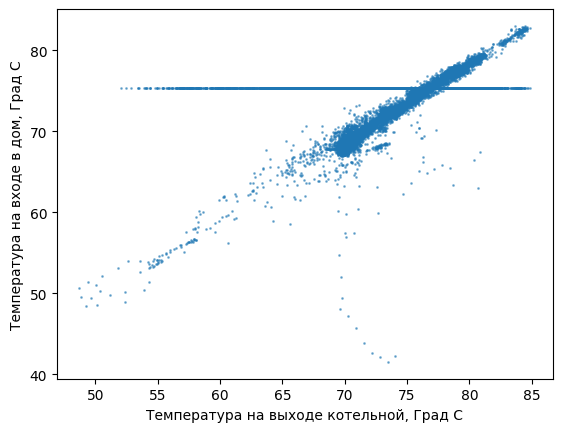

In [805]:
from boiler.timedelta.calculators.algo.std_var_time_delta_calculation_algorithm import StdVarTimeDeltaCalculationAlgorithm
from matplotlib import pyplot as plt

timestamps = boiler_df[column_names.TIMESTAMP].to_list()
boiler_temp = boiler_df[column_names.FORWARD_TEMP].to_numpy()
house_temp = house_df[column_names.FORWARD_TEMP].to_numpy()

calculator = StdVarTimeDeltaCalculationAlgorithm()
lag = calculator.find_lag(boiler_temp, house_temp)
print(lag)

moved_timestamps = timestamps[:-lag]
moved_boiler_temp = boiler_temp[:-lag]
moved_house_temp = house_temp[lag:]

print_boiler_house_scatter(moved_boiler_temp, moved_house_temp)

moved_df = pd.DataFrame({column_names.TIMESTAMP:moved_timestamps, 'x':moved_boiler_temp, 'y':moved_house_temp})

In [806]:
def print_temp_std_by_day(df):
    std_series = df.groupby(df[column_names.TIMESTAMP].dt.date)['y'].std()
    timestamps = moved_df[column_names.TIMESTAMP].dt.date.unique()
    plt.plot(timestamps, std_series.to_numpy())
    plt.xlabel('Дата')
    plt.ylabel('Стандартное отклонение, Град C')
    plt.show()

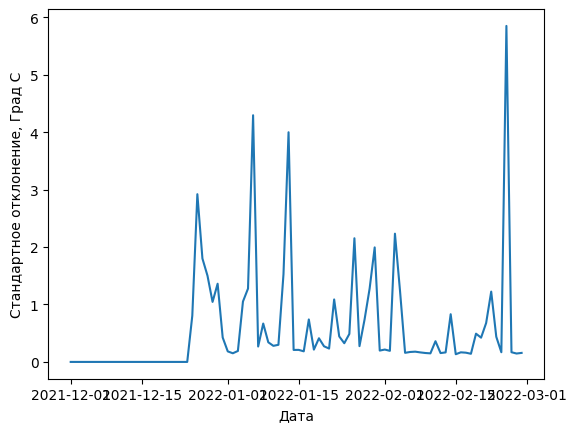

In [807]:
print_temp_std_by_day(moved_df)

In [808]:
def filter2(df, round_step=0.5, delta_to_drop=15):
    df = df.copy()
    
    df['rounded_x'] = df['x'].apply(lambda x: x // round_step * round_step)
    
    min_series = df.groupby('rounded_x')['y'].min()
    df['group_y_min'] = df['rounded_x'].apply(lambda x: min_series[x])

    max_series = df.groupby('rounded_x')['y'].max()
    df['group_y_max'] = df['rounded_x'].apply(lambda x: max_series[x])

    df["group_y_delta"] = df['group_y_max'] - df['group_y_min']
    
    df = df[df['group_y_delta'] < delta_to_drop]
    
    return df

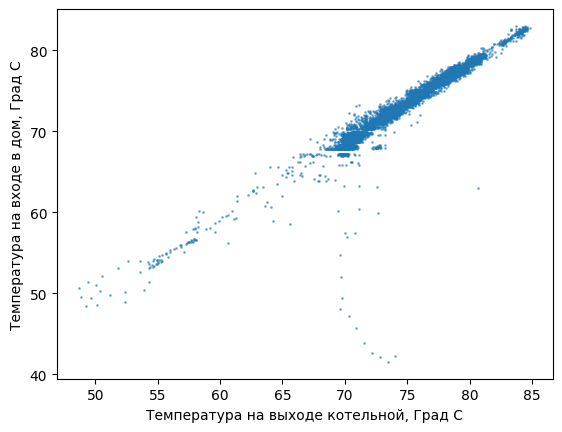

In [809]:
filtered_df2 = moved_df.copy()
filtered_df2[['x', 'y']] = filtered_df2[['y', 'x']]
filtered_df2 = filter2(filtered_df2, round_step=0.1, delta_to_drop=5)
filtered_df2[['x', 'y']] = filtered_df2[['y', 'x']]
print_boiler_house_scatter(filtered_df2['x'].to_numpy(), filtered_df2['y'].to_numpy())

In [810]:
def filter(df, round_step=0.5):
    df = df.copy()
    
    df['rounded_x'] = df['x'].apply(lambda x: x // round_step * round_step)
    mean_series = df.groupby('rounded_x')['y'].mean()
    df['mean_group_y'] = df['rounded_x'].apply(lambda x: mean_series[x])

    std_series = df.groupby('rounded_x')['y'].std()
    df['group_y_std'] = df['rounded_x'].apply(lambda x: std_series[x])
    
    df['delta_from_mean'] = (df['y']-df['mean_group_y']).abs()
    df = df[df['delta_from_mean'] < (df['group_y_std'])]
    
    return df

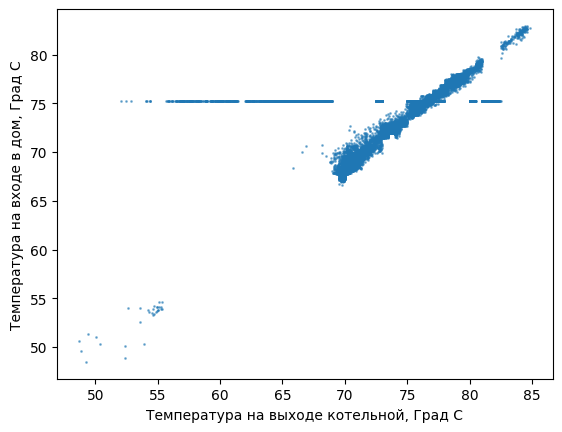

In [811]:
filtered_df = filter(moved_df)
print_boiler_house_scatter(filtered_df['x'].to_numpy(), filtered_df['y'].to_numpy())

coefficient of determination: 0.9821258775364103


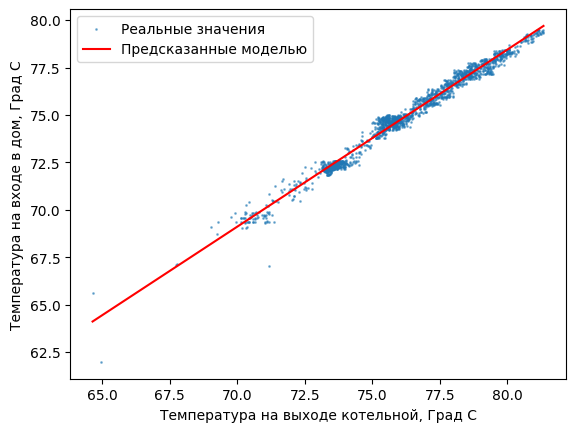

In [815]:
from sklearn.linear_model import LinearRegression

train_start_timestamp = start_timestamp #+ pd.Timedelta(days=30)
train_end_timestamp = train_start_timestamp + pd.Timedelta(days=30)

#train_df = filtered_df2.copy() 
train_df = moved_df.copy()
train_df = train_df[train_df[column_names.TIMESTAMP] >= train_start_timestamp]
train_df = train_df[train_df[column_names.TIMESTAMP] < train_end_timestamp]
train_df = filter(train_df)

train_x_data = train_df['x'].to_numpy().reshape((-1, 1))
train_y_data = train_df['y'].to_numpy()
model = LinearRegression(n_jobs=-1)
model.fit(train_x_data, train_y_data)

r_sq = model.score(train_x_data, train_y_data)
print(f"coefficient of determination: {r_sq}")

x_pred = np.array([train_df['x'].min(), train_df['x'].max()])
y_pred = model.predict(x_pred.reshape((-1, 1)))
print_boiler_house_scatter_with_pred(
    train_df['x'].to_numpy(), 
    train_df['y'].to_numpy(),
    x_pred,
    y_pred
)

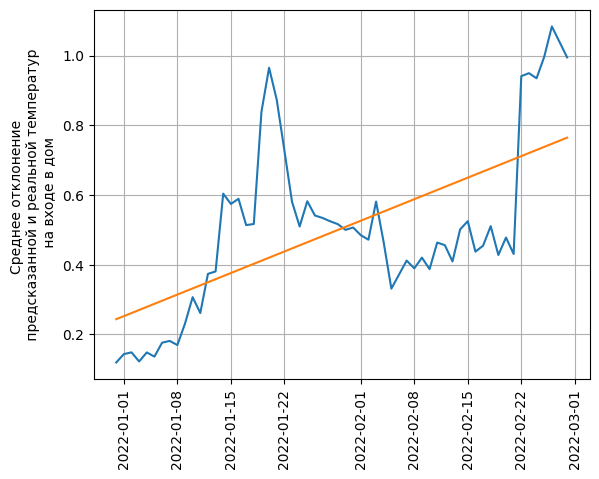

0.2605424793101237


In [816]:
start_test_timestamp = train_end_timestamp
end_test_timestamp = end_timestamp

#test_df = filtered_df2.copy() 
test_df = moved_df.copy()
test_df = test_df[test_df[column_names.TIMESTAMP] >= start_test_timestamp]
test_df = test_df[test_df[column_names.TIMESTAMP] < end_test_timestamp]

step = pd.Timedelta(days=1)
i_count = (end_test_timestamp-start_test_timestamp)//step
x_dev = []
y_dev = []
for i in range(i_count):
    timestamp1 = start_test_timestamp + i * step
    x_dev.append(timestamp1)
    timestamp2 = timestamp1 + step

    df = test_df[test_df[column_names.TIMESTAMP] >= timestamp1]
    df = df[df[column_names.TIMESTAMP] < timestamp2]
    df = filter(df)
    
    boiler_temp =  df['x'].to_numpy()
    house_temp = df['y'].to_numpy()
    predicted_house_temp = model.predict(boiler_temp.reshape((-1, 1)))
    abs_delta = np.abs(house_temp - predicted_house_temp)
    y_dev.append(abs_delta.mean())

plt.plot(x_dev, y_dev)
x = np.arange(len(x_dev))
z = np.polyfit(x, np.array(y_dev), 1)
p = np.poly1d(z)
plt.plot(x_dev, p(x))
plt.ylabel("Среднее отклонение \n предсказанной и реальной температур \n на входе в дом")
plt.grid(True)
plt.xticks(rotation = 90)
plt.show()
print((p(x[-1]) - p(x[0]))/len(x)*30)